In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


Here we use a corpus of 438 MIDI files from [MuseData](http://old.musedata.org).

Those files refers to 139 classical music compositions, of which each file can represent a specific movement.

MuseData provides also some metadata, like the composer name, the scholar catalogue number, a label for the movement. 

Each composition is interlinked against the [DOREMUS knowledge base](http://data.doremus.org), a specialised music dataset dataset which gives access to the previously mentioned metadata and much more, such as the genre.

In [2]:
data = np.loadtxt('./dataset/vectors.txt')
genres = np.loadtxt('./dataset/genre.txt', dtype=np.str, delimiter=',')

In [3]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [4]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, short=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 8))
    n = cm.shape[1]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set( 
            xticks=np.arange(n),
            yticks=np.arange(n),
            ylim= (n-0.5, -0.5),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    fnames = ['musedata', short]
    if normalize: fnames.append('norm')
    filename = 'plot/' + '_'.join(fnames) + '.pdf'
    fig.savefig(filename, dpi=fig.dpi)

In [43]:
def clean_and_filter(what, min_count = 15, sort_by='value'):
    """
    Remove the '?' items and keep only the ones
    with more than min_count occurrences
    """
    u = Counter(what) # map label -> n. occurences
    
    enough_big = [(m not in ['?', '0'] and u[m] > min_count) for m in what]

    data_filtered = data[enough_big]
    what_filtered = what[enough_big]
    
    if sort_by =='value':
        x = Counter(what_filtered).most_common()
    elif sort_by == 'key':
        x = sorted(Counter(what_filtered).items())
    else:
        x = Counter(what_filtered).items()
        
    labels, values = zip(*x)
    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(20,6))
    plt.bar(indexes, values, width, align="center")
    plt.xticks(indexes - 1  + width, labels, rotation=45)
    plt.show()

    return data_filtered, what_filtered

### Experiment 1: Genre

In DOREMUS, genres are very precise and go beyond the macro-genre "Classical"

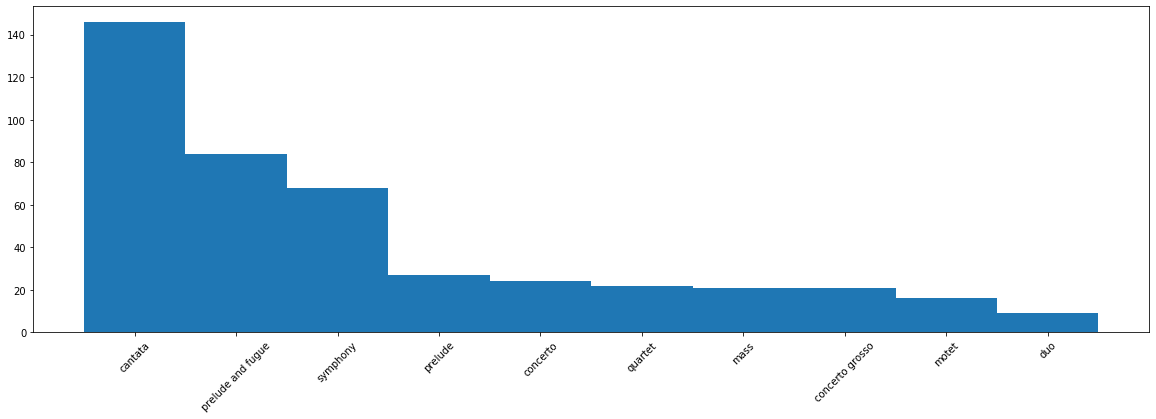

In [6]:
genres_filtered = clean_and_filter(genres, 0)

In [7]:
labels_1hot = onehot_labels(genres)
    
onehot2str(labels_1hot[0])

'symphony'

In [8]:
labels_1hot.shape

(438, 10)

In [9]:
num_input = data.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 10)

In [10]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [11]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32,
                                verbose=0)

In [12]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=KFold(shuffle=True, random_state=23333), verbose=0)
scores

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
W0826 10:53:35.987364 4558890432 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0826 10:53:36.079644 4558890432 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as

array([0.9308219 , 0.93219185, 0.93698621])

In [13]:
score = {}
score['genre'] = np.mean(scores)
score['genre']

0.9333333174387614

In [14]:
neural_network.fit(data, labels_1hot, verbose=0)
predicted = neural_network.predict(data)

#### Confusion matrix, without normalization

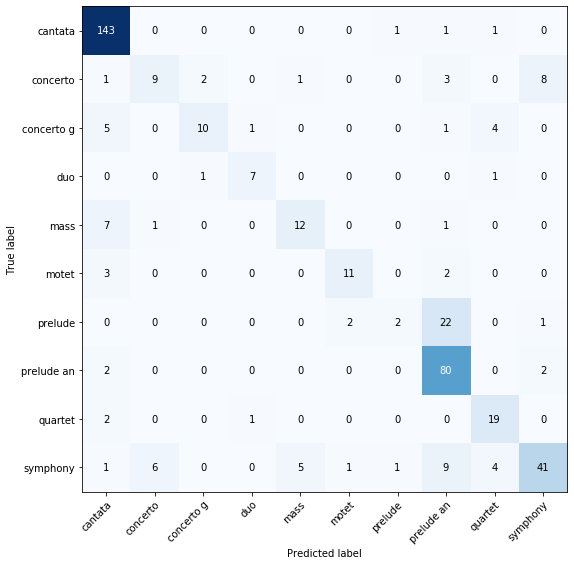

In [15]:
plot_confusion_matrix(labels_1hot, predicted, classes=genres, short='genre')

#### Normalized confusion matrix

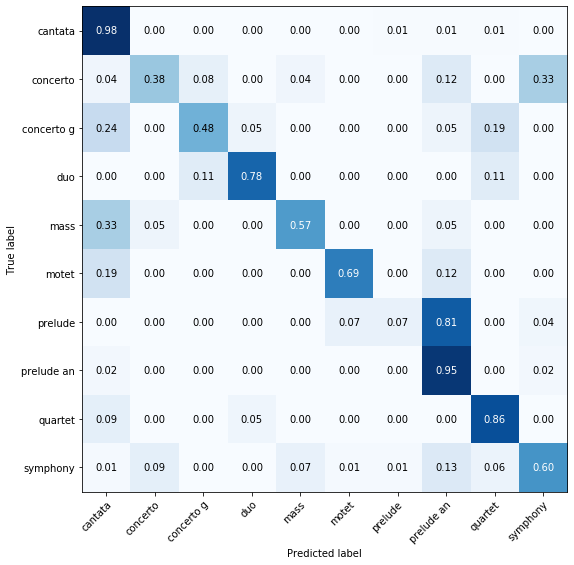

In [16]:
plot_confusion_matrix(labels_1hot, predicted, classes=genres, normalize=True, short='genre')

### Experiment 2: Composer

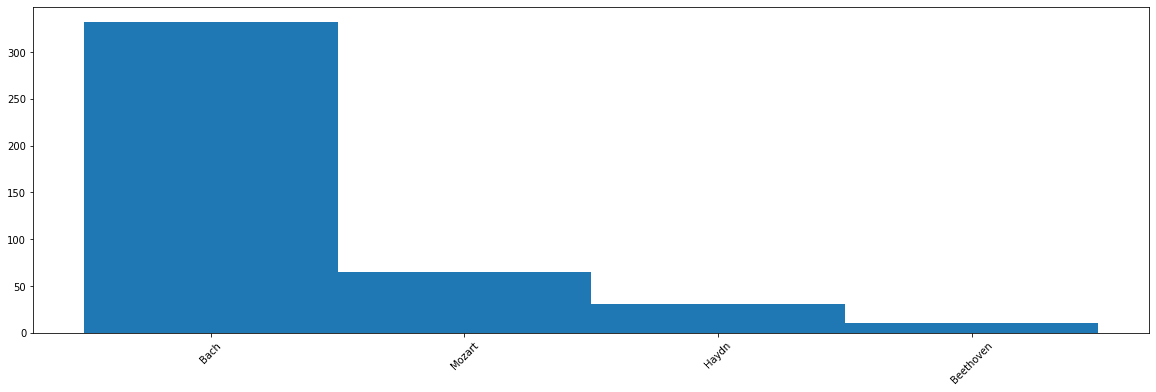

In [17]:
composers = np.loadtxt('./dataset/composer.txt', dtype=np.str, delimiter=',')
composer_filtered = clean_and_filter(composers, 0)

In [18]:
labels_1hot = onehot_labels(composers)
num_output = labels_1hot.shape[1]

num_output

4

In [19]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose = 0)

In [20]:
scores = cross_val_score(neural_network, data, labels_1hot, cv=10, verbose=0)
scores

array([0.86931819, 0.86931819, 0.90909094, 0.91477275, 0.9375    ,
       0.94886363, 0.94318181, 0.92045456, 0.97674417, 1.        ])

In [21]:
score['composer'] = np.mean(scores)
np.mean(scores)

0.928924423456192

In [22]:
neural_network.fit(data, labels_1hot, verbose=0)
predicted = neural_network.predict(data)

#### Confusion matrix, without normalization

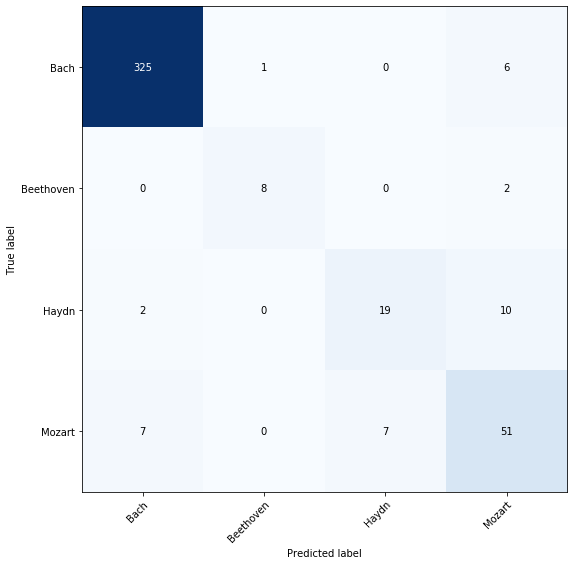

In [23]:
plot_confusion_matrix(labels_1hot, predicted, classes=composers, short='composer')

#### Normalized confusion matrix

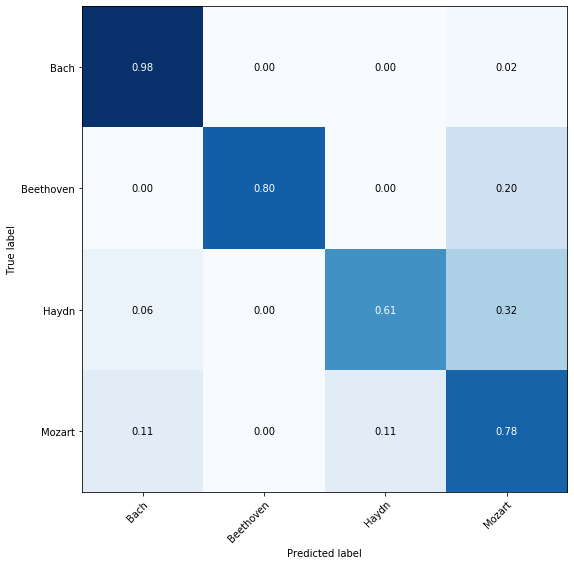

In [24]:
plot_confusion_matrix(labels_1hot, predicted, classes=composers, normalize=True, short='composer')

### Experiment 3: Movement

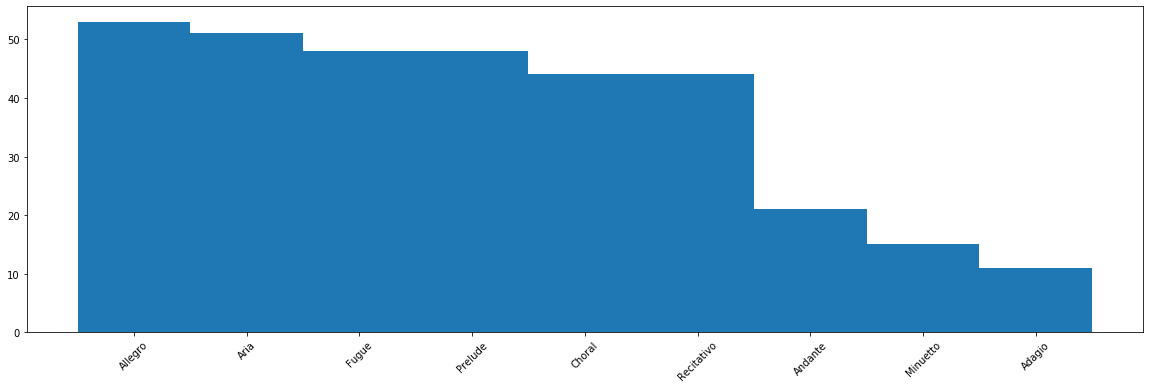

Distinct movement tag considered:


9

In [25]:
mvt = np.loadtxt('./dataset/mvt.txt', dtype=np.str, delimiter=',')
data_filtered, mvt_filtered = clean_and_filter(mvt, min_count=9)

print('Distinct movement tag considered:')
len(np.unique(mvt_filtered))

In [26]:
labels_1hot = onehot_labels(mvt_filtered)
num_output = labels_1hot.shape[1]
num_output

9

In [27]:
data_filtered.shape

(335, 100)

In [28]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [29]:
scores = cross_val_score(neural_network, data_filtered, labels_1hot, cv=10, verbose=0)
scores

Epoch 1/100
301/301 [==============================] - 0s 609us/sample - loss: 0.4470 - acc: 0.8387
Epoch 2/100
301/301 [==============================] - 0s 67us/sample - loss: 0.3471 - acc: 0.8889
Epoch 3/100
301/301 [==============================] - 0s 60us/sample - loss: 0.3395 - acc: 0.8889
Epoch 4/100
301/301 [==============================] - 0s 60us/sample - loss: 0.3275 - acc: 0.8889
Epoch 5/100
301/301 [==============================] - 0s 61us/sample - loss: 0.3217 - acc: 0.8911
Epoch 6/100
301/301 [==============================] - 0s 60us/sample - loss: 0.3178 - acc: 0.8941
Epoch 7/100
301/301 [==============================] - 0s 59us/sample - loss: 0.3138 - acc: 0.8922
Epoch 8/100
301/301 [==============================] - 0s 61us/sample - loss: 0.3139 - acc: 0.8926
Epoch 9/100
301/301 [==============================] - 0s 66us/sample - loss: 0.3110 - acc: 0.8933
Epoch 10/100
301/301 [==============================] - 0s 62us/sample - loss: 0.3054 - acc: 0.8915
Epoch 11

301/301 [==============================] - 0s 59us/sample - loss: 0.1715 - acc: 0.9188
Epoch 84/100
301/301 [==============================] - 0s 61us/sample - loss: 0.1681 - acc: 0.9214
Epoch 85/100
301/301 [==============================] - 0s 61us/sample - loss: 0.1673 - acc: 0.9214
Epoch 86/100
301/301 [==============================] - 0s 58us/sample - loss: 0.1757 - acc: 0.9151
Epoch 87/100
301/301 [==============================] - 0s 60us/sample - loss: 0.1844 - acc: 0.9118
Epoch 88/100
301/301 [==============================] - 0s 59us/sample - loss: 0.1834 - acc: 0.9144
Epoch 89/100
301/301 [==============================] - 0s 61us/sample - loss: 0.1646 - acc: 0.9217
Epoch 90/100
301/301 [==============================] - 0s 59us/sample - loss: 0.1677 - acc: 0.9203
Epoch 91/100
301/301 [==============================] - 0s 62us/sample - loss: 0.1700 - acc: 0.9243
Epoch 92/100
301/301 [==============================] - 0s 64us/sample - loss: 0.1754 - acc: 0.9192
Epoch 93/100


301/301 [==============================] - 0s 57us/sample - loss: 0.2356 - acc: 0.8948
Epoch 46/100
301/301 [==============================] - 0s 57us/sample - loss: 0.2302 - acc: 0.8989
Epoch 47/100
301/301 [==============================] - 0s 62us/sample - loss: 0.2304 - acc: 0.9007
Epoch 48/100
301/301 [==============================] - 0s 65us/sample - loss: 0.2321 - acc: 0.8977
Epoch 49/100
301/301 [==============================] - 0s 56us/sample - loss: 0.2275 - acc: 0.9029
Epoch 50/100
301/301 [==============================] - 0s 54us/sample - loss: 0.2282 - acc: 0.8981
Epoch 51/100
301/301 [==============================] - 0s 58us/sample - loss: 0.2198 - acc: 0.8996
Epoch 52/100
301/301 [==============================] - 0s 57us/sample - loss: 0.2177 - acc: 0.9007
Epoch 53/100
301/301 [==============================] - 0s 53us/sample - loss: 0.2149 - acc: 0.9073
Epoch 54/100
301/301 [==============================] - 0s 56us/sample - loss: 0.2116 - acc: 0.9051
Epoch 55/100


301/301 [==============================] - 0s 69us/sample - loss: 0.3189 - acc: 0.8915
Epoch 8/100
301/301 [==============================] - 0s 71us/sample - loss: 0.3148 - acc: 0.8933
Epoch 9/100
301/301 [==============================] - 0s 56us/sample - loss: 0.3142 - acc: 0.8915
Epoch 10/100
301/301 [==============================] - 0s 64us/sample - loss: 0.3120 - acc: 0.8911
Epoch 11/100
301/301 [==============================] - 0s 64us/sample - loss: 0.3078 - acc: 0.8929
Epoch 12/100
301/301 [==============================] - 0s 61us/sample - loss: 0.3049 - acc: 0.8918
Epoch 13/100
301/301 [==============================] - 0s 66us/sample - loss: 0.3022 - acc: 0.8922
Epoch 14/100
301/301 [==============================] - 0s 71us/sample - loss: 0.3029 - acc: 0.8922
Epoch 15/100
301/301 [==============================] - 0s 61us/sample - loss: 0.2998 - acc: 0.8918
Epoch 16/100
301/301 [==============================] - 0s 56us/sample - loss: 0.2942 - acc: 0.8918
Epoch 17/100
30

301/301 [==============================] - 0s 57us/sample - loss: 0.1747 - acc: 0.9166
Epoch 90/100
301/301 [==============================] - 0s 60us/sample - loss: 0.1695 - acc: 0.9162
Epoch 91/100
301/301 [==============================] - 0s 59us/sample - loss: 0.1701 - acc: 0.9192
Epoch 92/100
301/301 [==============================] - 0s 60us/sample - loss: 0.1610 - acc: 0.9232
Epoch 93/100
301/301 [==============================] - 0s 58us/sample - loss: 0.1684 - acc: 0.9169
Epoch 94/100
301/301 [==============================] - 0s 58us/sample - loss: 0.1624 - acc: 0.9221
Epoch 95/100
301/301 [==============================] - 0s 60us/sample - loss: 0.1628 - acc: 0.9247
Epoch 96/100
301/301 [==============================] - 0s 66us/sample - loss: 0.1662 - acc: 0.9217
Epoch 97/100
301/301 [==============================] - 0s 59us/sample - loss: 0.1966 - acc: 0.9051
Epoch 98/100
301/301 [==============================] - 0s 56us/sample - loss: 0.2017 - acc: 0.9048
Epoch 99/100


302/302 [==============================] - 0s 58us/sample - loss: 0.2007 - acc: 0.9043
Epoch 52/100
302/302 [==============================] - 0s 55us/sample - loss: 0.2017 - acc: 0.9091
Epoch 53/100
302/302 [==============================] - 0s 57us/sample - loss: 0.1907 - acc: 0.9091
Epoch 54/100
302/302 [==============================] - 0s 57us/sample - loss: 0.1945 - acc: 0.9080
Epoch 55/100
302/302 [==============================] - 0s 63us/sample - loss: 0.1984 - acc: 0.9106
Epoch 56/100
302/302 [==============================] - 0s 59us/sample - loss: 0.1879 - acc: 0.9128
Epoch 57/100
302/302 [==============================] - 0s 51us/sample - loss: 0.1943 - acc: 0.9146
Epoch 58/100
302/302 [==============================] - 0s 57us/sample - loss: 0.1917 - acc: 0.9062
Epoch 59/100
302/302 [==============================] - 0s 52us/sample - loss: 0.1864 - acc: 0.9150
Epoch 60/100
302/302 [==============================] - 0s 55us/sample - loss: 0.1968 - acc: 0.9051
Epoch 61/100


302/302 [==============================] - 0s 61us/sample - loss: 0.3025 - acc: 0.8915
Epoch 14/100
302/302 [==============================] - 0s 63us/sample - loss: 0.2993 - acc: 0.8889
Epoch 15/100
302/302 [==============================] - 0s 68us/sample - loss: 0.2940 - acc: 0.8937
Epoch 16/100
302/302 [==============================] - 0s 71us/sample - loss: 0.2912 - acc: 0.8922
Epoch 17/100
302/302 [==============================] - 0s 69us/sample - loss: 0.2857 - acc: 0.8918
Epoch 18/100
302/302 [==============================] - 0s 67us/sample - loss: 0.2832 - acc: 0.8937
Epoch 19/100
302/302 [==============================] - 0s 93us/sample - loss: 0.2886 - acc: 0.8922
Epoch 20/100
302/302 [==============================] - 0s 83us/sample - loss: 0.2883 - acc: 0.8907
Epoch 21/100
302/302 [==============================] - 0s 72us/sample - loss: 0.2773 - acc: 0.8951
Epoch 22/100
302/302 [==============================] - 0s 64us/sample - loss: 0.2735 - acc: 0.8926
Epoch 23/100


302/302 [==============================] - 0s 62us/sample - loss: 0.1630 - acc: 0.9253
Epoch 96/100
302/302 [==============================] - 0s 60us/sample - loss: 0.1670 - acc: 0.9213
Epoch 97/100
302/302 [==============================] - 0s 65us/sample - loss: 0.1632 - acc: 0.9227
Epoch 98/100
302/302 [==============================] - 0s 57us/sample - loss: 0.1615 - acc: 0.9238
Epoch 99/100
302/302 [==============================] - 0s 55us/sample - loss: 0.1830 - acc: 0.9128
Epoch 100/100
33/33 [==============================] - 0s 5ms/sample - loss: 0.1901 - acc: 0.8923
Epoch 1/100
302/302 [==============================] - 0s 764us/sample - loss: 0.4379 - acc: 0.8705
Epoch 2/100
302/302 [==============================] - 0s 62us/sample - loss: 0.3477 - acc: 0.8889
Epoch 3/100
302/302 [==============================] - 0s 61us/sample - loss: 0.3344 - acc: 0.8889
Epoch 4/100
302/302 [==============================] - 0s 63us/sample - loss: 0.3249 - acc: 0.8878
Epoch 5/100
302/30

array([0.89869279, 0.92483664, 0.91176468, 0.91503268, 0.89542484,
       0.90572393, 0.89562297, 0.90235692, 0.89225584, 0.87205392])

In [30]:
score['mvt'] = np.mean(scores)
score['mvt']

0.9013765215873718

In [31]:
neural_network.fit(data_filtered, labels_1hot, verbose=0)
predicted = neural_network.predict(data_filtered)

#### Confusion matrix, without normalization

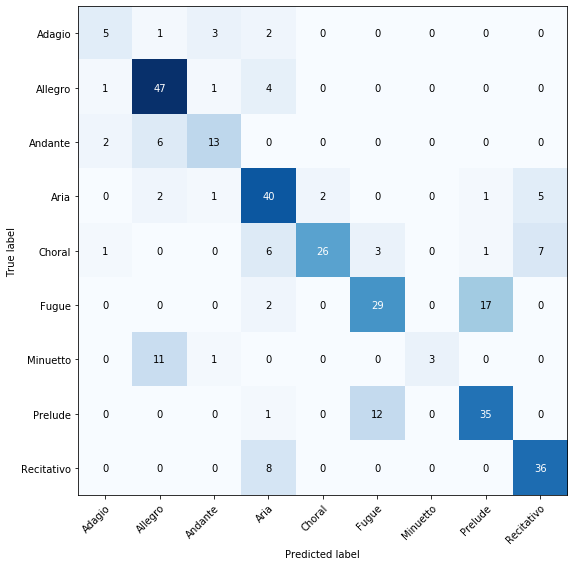

In [32]:
plot_confusion_matrix(labels_1hot, predicted, classes=mvt_filtered, short='mvt')

#### Normalized confusion matrix

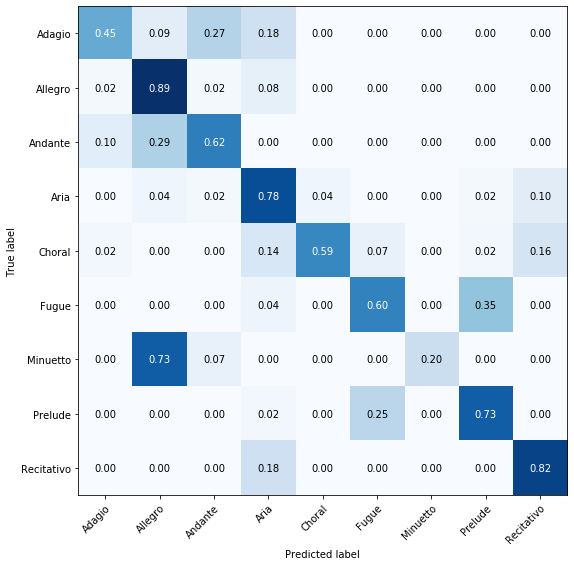

In [33]:
plot_confusion_matrix(labels_1hot, predicted, classes=mvt_filtered, normalize=True, short='mvt')

### Experiment 4: Instrument

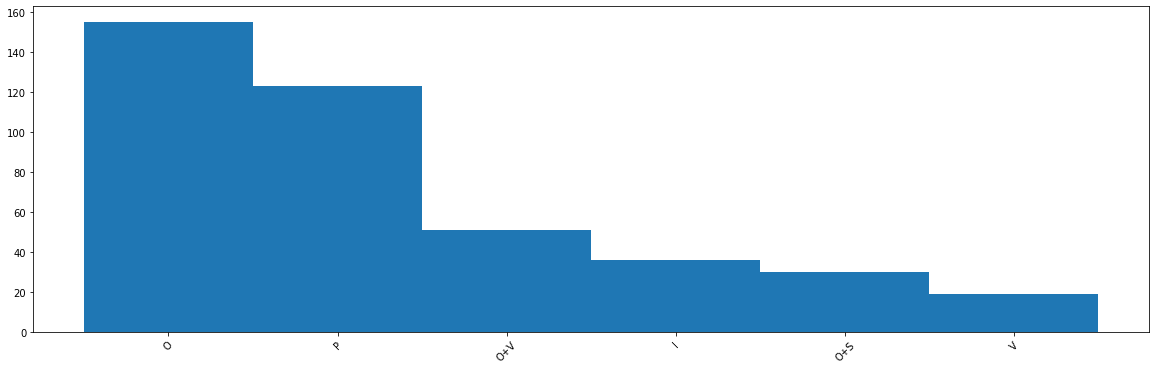

Distinct instrument considered:


6

In [34]:
instrument = np.loadtxt('./dataset/instrument.txt', dtype=np.str, delimiter=',')
data_filtered, instrument_filtered = clean_and_filter(instrument, min_count=9)

print('Distinct instrument considered:')
len(np.unique(instrument_filtered))

In [35]:
labels_1hot = onehot_labels(instrument_filtered)
num_output = labels_1hot.shape[1]
num_output

6

In [36]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

In [37]:
neural_network.fit(data_filtered, labels_1hot, verbose=0)
predicted = neural_network.predict(data_filtered)

In [38]:
scores = cross_val_score(neural_network, data_filtered, labels_1hot, cv=10, verbose=0)
scores

array([0.84920639, 0.85714287, 0.87301588, 0.89682543, 0.89024389,
       0.84959346, 0.88211387, 0.91869915, 0.94715446, 0.86178857])

In [39]:
score['instrument'] = np.mean(scores)

In [40]:
score

{'genre': 0.9333333174387614,
 'composer': 0.928924423456192,
 'mvt': 0.9013765215873718,
 'instrument': 0.8825783967971802}

#### Confusion matrix, without normalization

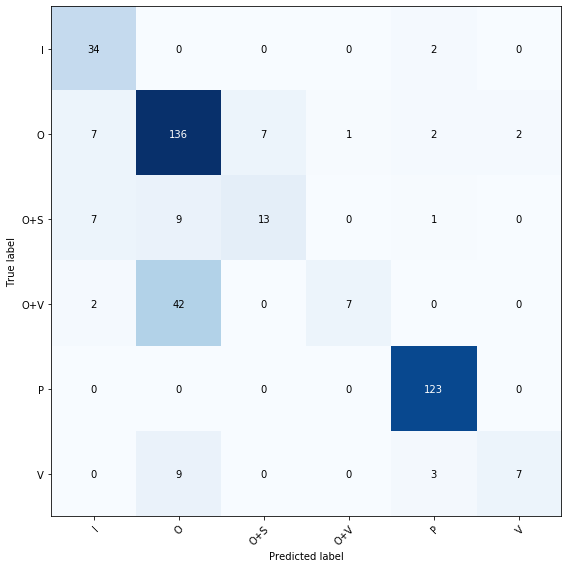

In [41]:
plot_confusion_matrix(labels_1hot, predicted, classes=instrument_filtered, short='instrument')

#### Normalized confusion matrix

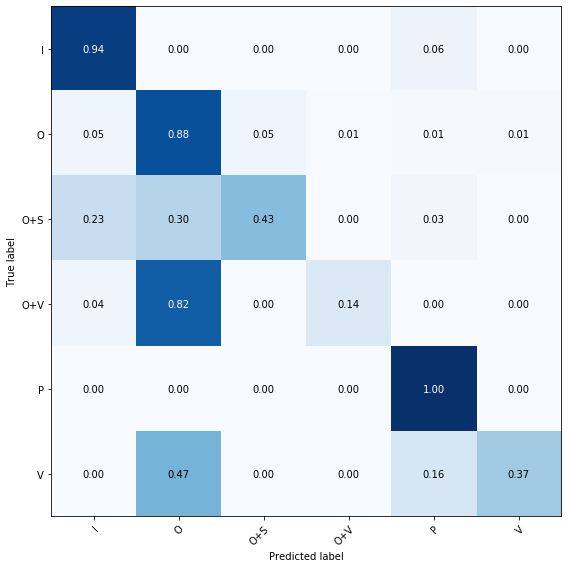

In [42]:
plot_confusion_matrix(labels_1hot, predicted, classes=instrument_filtered, normalize=True, short='instrument')